In [107]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import chi2, spearmanr, pearsonr

from matplotlib_venn import venn2

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [124]:
def load_nef_values(load=False):
    if load:
        values = pd.read_pickle("data/nef_values_condensed.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
        values = pd.concat(dfs, ignore_index=True)
        values['dvs'] = values['va'] - values['vb']
        values['dva'] = values['vl'] - values['vr']
        values = values.drop(columns='block_type')
        values = values.drop(columns='before')
        values = values.drop(columns='after')
        values = values.drop(columns='acc')
        values.to_pickle("data/nef_values_condensed.pkl")
    return values

In [125]:
def load_rl_values(load=False):
    if load:
        values = pd.read_pickle("data/rl_values_condensed.pkl")
    else:
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in range(1, 25):
                    for trial in range(1, 81):
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        try:
                            dfs.append(pd.read_pickle(f'data/emp_spikes/{file}_values.pkl'))
                        except:
                            pass
        values = pd.concat(dfs, ignore_index=True)
        values.rename(columns={'chosen location': 'cloc'}, inplace=True)
        values.rename(columns={'chosen letter': 'clet'}, inplace=True)
        values.to_pickle("data/rl_values_condensed.pkl")
    return values

In [4]:
def load_spikes(load=True, spike_type='nef'):
    filename = f"{spike_type}_spikes_dataframe"
    loadname = "nef" if spike_type=='nef' else 'emp'
    if load:
        dataframe_spikes = pd.read_pickle(f"data/{filename}.pkl")
    else:
        dfs = []
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            for session in emp['session'].unique():
                print(monkey, session)
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        if spike_type=='nef':
                            spikes = np.load(f"data/{loadname}_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['vwa']
                        else:
                            try:
                                spikes = np.load(f"data/{loadname}_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['spikes']
                            except:
                                print(monkey, session, block, trial)
                                continue
                        n_neurons = spikes.shape[0]
                        df = pd.DataFrame()
                        df['monkey'] = [monkey for _ in range(n_neurons)]
                        df['session'] = [session for _ in range(n_neurons)]
                        df['block'] = [block for _ in range(n_neurons)]
                        df['trial'] = [trial for _ in range(n_neurons)]
                        df['neuron'] = [n for n in range(n_neurons)]
                        df['spikes'] = [spikes[n] for n in range(n_neurons)]
                        dfs.append(df)
        dataframe_spikes = pd.concat(dfs, ignore_index=True)
        dataframe_spikes.to_pickle(f"data/{filename}.pkl")
    return dataframe_spikes

In [5]:
nef_spikes = load_spikes(load=True, spike_type='nef')

In [6]:
monkey_spikes = load_spikes(load=True, spike_type='monkey')

In [126]:
nef_values = load_nef_values()

In [127]:
rl_values = load_rl_values()

In [9]:
nef_weights = pd.read_pickle("data/nef_weight_vwa.pkl")

In [10]:
monkey_weights = pd.read_pickle("data/monkey_weight.pkl")

In [12]:
def compute_x_bins(df_values, target_variable, method='uniform', n_bins=10):
    x = df_values[target_variable].dropna()
    if method == 'uniform':
        # Equal-width bins between min and max
        bin_edges = np.linspace(x.min(), x.max(), n_bins + 1)
    elif method == 'quantile':
        # Quantile-based bin edges (equal number of samples per bin)
        bin_edges = np.unique(np.quantile(x, q=np.linspace(0, 1, n_bins + 1)))
    else:
        raise ValueError("method must be either 'uniform' or 'quantile'")
    return bin_edges

In [13]:
def plot_multi_variable_tuning(
    df_spikes, df_values, df_weights,
    monkey, session,
    all_variables, target_variable,
    top_n=10, bin_method='uniform', n_bins=10, order=2):

    # Get top N neurons by weight
    df_filtered_weights = df_weights.query("monkey==@monkey & session==@session & variable==@target_variable")
    df_avg_weights = df_filtered_weights.groupby(['neuron'], as_index=False)['weight'].mean()
    top_neurons = df_avg_weights.sort_values('weight', ascending=False).head(top_n)['neuron'].tolist()

    # Filter spikes and values
    merge_keys = ['monkey', 'session', 'block', 'trial']
    df_spikes_filtered = df_spikes[
        (df_spikes['monkey'] == monkey) &
        (df_spikes['session'] == session) &
        (df_spikes['neuron'].isin(top_neurons))
    ]
    df_values_filtered = df_values[
        (df_values['monkey'] == monkey) &
        (df_values['session'] == session)
    ]
    df_merged = pd.merge(df_spikes_filtered, df_values_filtered, on=merge_keys)

    n_vars = len(all_variables)
    fig, axes = plt.subplots(1, n_vars, figsize=(3 * n_vars, 3), sharey=True)
    if n_vars == 1:
        axes = [axes]  # Make iterable
    for idx, var in enumerate(all_variables):
        ax = axes[idx]
        sns.regplot(data=df_merged, x=var, y='spikes', x_bins=10, ax=ax, color=palette[0])

        # x_bins = compute_x_bins(df_merged, var, method=bin_method, n_bins=n_bins)
        # df_merged['bin'] = pd.cut(df_merged[var], bins=x_bins, include_lowest=True)
        # df_merged['bin_center'] = df_merged['bin'].apply(lambda b: (b.left + b.right) / 2)
        # sns.lineplot(data=df_merged, x='bin_center', y='spikes', ax=ax, color=palette[0])

        if var == target_variable:
            for spine in ax.spines.values():
                spine.set_linewidth(2)
        
        ax.set_ylabel("Spike Count" if idx == 0 else "")
        ax.set_xlabel(var)
        ax.set(xlim=(-1,1))

    fig.suptitle(f"Averaged Tuning (Top {top_n}), Monkey {monkey}, Session {session}",fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 1. Tuning Curve visualization

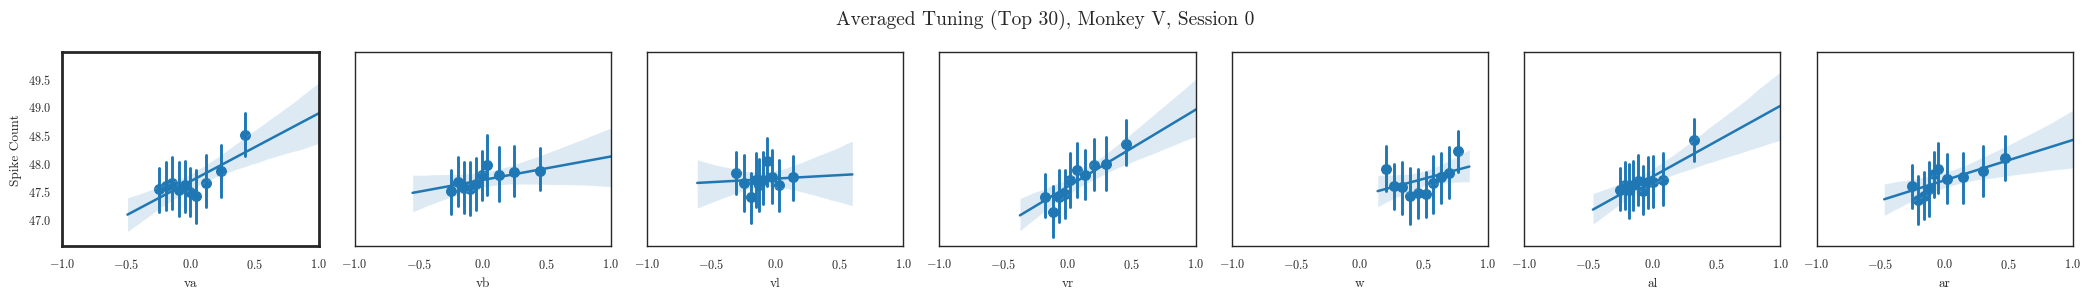

In [14]:
spike_type = 'nef'
monkey = 'V'
session = 0
target_variable = 'va'
all_variables = ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar']
top_n = 30

if spike_type=='nef':
    W = nef_weights
    S = nef_spikes
    V = nef_values
else:
    W = monkey_weights
    S = monkey_spikes
    V = rl_values

plot_multi_variable_tuning(S, V, W,
        monkey=monkey, session=session, top_n=top_n,
        all_variables=all_variables,
        target_variable=target_variable,
        bin_method='uniform')

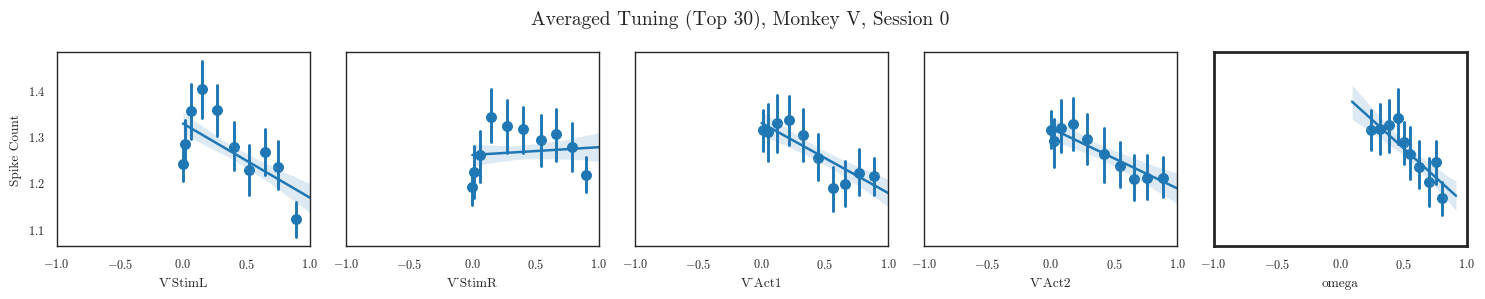

In [165]:
spike_type = 'monkey'
monkey = 'V'
session = 0
target_variable = 'omega'
all_variables = ['V_StimL', 'V_StimR', 'V_Act1', 'V_Act2', 'omega']
top_n = 30

if spike_type=='nef':
    W = nef_weights
    S = nef_spikes
    V = nef_values
else:
    W = monkey_weights
    S = monkey_spikes
    V = rl_values

plot_multi_variable_tuning(S, V, W,
        monkey=monkey, session=session, top_n=top_n,
        all_variables=all_variables,
        target_variable=target_variable,
        bin_method='uniform')

# 2. GLM and ANOVA

In [149]:
def run_glm_and_anova(df_spikes, df_values, monkey, session, variables, family=sm.families.Poisson()):
    merge_keys = ['monkey', 'session', 'block', 'trial']
    df_spk = df_spikes.query("monkey==@monkey & session==@session")
    df_val = df_values.query("monkey==@monkey & session==@session")
    df_merged = pd.merge(df_spk, df_val, on=merge_keys)
    neurons = df_merged['neuron'].unique()

    pval_table = pd.DataFrame(index=neurons, columns=variables)
    effect_size_table = pd.DataFrame(index=neurons, columns=variables)

    # ---- A: Compute VIF across all trials for this monkey-session ----
    X_vif = df_merged[variables].copy()
    X_vif = sm.add_constant(X_vif)  # Add intercept
    vif_values = pd.Series(
        [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
        index=X_vif.columns
    )
    
    for neuron in neurons:
        df_neuron = df_merged[df_merged['neuron'] == neuron].copy()
        # Fit full model
        full_formula = 'spikes ~ ' + ' + '.join(variables)
        try:
            full_model = smf.glm(formula=full_formula, data=df_neuron, family=family).fit()
            ll_full = full_model.llf
        except ValueError as e:
            print(f"Neuron {neuron} failed: {e}")
            continue
        # Save coefficients (effect sizes)
        for var in variables:
            if var in full_model.params:
                effect_size_table.loc[neuron, var] = full_model.params[var]
            else:
                effect_size_table.loc[neuron, var] = np.nan
        # Loop over variables: drop one at a time
        for var in variables:
            reduced_vars = [v for v in variables if v != var]
            reduced_formula = 'spikes ~ ' + ' + '.join(reduced_vars)
            reduced_model = smf.glm(formula=reduced_formula, data=df_neuron, family=family).fit()
            ll_reduced = reduced_model.llf
            lr_stat = 2 * (ll_full - ll_reduced)
            p_val = chi2.sf(lr_stat, df=1)
            pval_table.loc[neuron, var] = p_val

    return pval_table.astype(float), effect_size_table.astype(float), vif_values

In [109]:
def plot_encoding_heatmap(pvals, sort_by=None, top_n=200, vmin=0, vmax=10):
    logp = -np.log10(pvals)
    
    if sort_by and sort_by in logp.columns:
        logp = logp.sort_values(by=sort_by, ascending=False)

    subset = logp.head(top_n)
    
    plt.figure(figsize=(12, max(6, top_n // 10)))
    sns.heatmap(subset, cmap='viridis', vmin=vmin, vmax=vmax, cbar_kws={'label': '-log10(p)'})
    plt.title(f'Tuning Profile Heatmap (Top {top_n} neurons)')
    plt.xlabel('Variable')
    plt.ylabel('Neuron')
    plt.tight_layout()
    plt.show()

In [135]:
def plot_all_pairwise_logp_scatter_trend(pvals, alpha=0.01, figsize_per_plot=2):
    logp = -np.log10(pvals)
    variables = pvals.columns.tolist()
    n_vars = len(variables)

    # Create subplots WITHOUT shared axes
    fig, axes = plt.subplots(
        n_vars, n_vars,
        figsize=(figsize_per_plot * n_vars, figsize_per_plot * n_vars),
        sharex=False, sharey=False
    )

    threshold = -np.log10(alpha)

    # Store off-diagonal axes for linking
    offdiag_axes = []

    for i, var_x in enumerate(variables):
        for j, var_y in enumerate(variables):
            ax = axes[j, i]  # rows = var_y, cols = var_x

            if i == j:
                # Diagonal: histogram of single variable
                vals = logp[var_x].dropna()
                sns.histplot(vals, bins=30, ax=ax, color='gray')
                ax.axvline(threshold, color='red', linestyle='--', lw=1)
                # ax.set_title(f'{var_x}')
                ax.set_xlabel('')
                ax.set_ylabel('')
            else:
                x = logp[var_x]
                y = logp[var_y]
                mask = x.notna() & y.notna()
                x = x[mask]
                y = y[mask]

                sns.regplot(x=x, y=y, ax=ax, scatter_kws={'s': 1, 'alpha': 1}, line_kws={'color': palette[1]})

                ax.axhline(threshold, color='red', linestyle='--', lw=1)
                ax.axvline(threshold, color='red', linestyle='--', lw=1)

                try:
                    r, _ = spearmanr(x, y)
                    ax.text(0.05, 0.9, f'rho={r:.2f}', transform=ax.transAxes,
                            fontsize=9, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
                except:
                    pass

                offdiag_axes.append((j, i, ax))

            # Only bottom row gets x labels
            if j == n_vars - 1:
                ax.set_xlabel(f'{var_x}')
            else:
                ax.set_xlabel('')
                ax.set_xticklabels([])

            # Only first column gets y labels
            if i == 0:
                ax.set_ylabel(f'{var_y}')
            else:
                ax.set_ylabel('')
                ax.set_yticklabels([])

    # Now share axes manually for off-diagonal plots in each row and column
    # Share x axes among each column of off-diagonal axes
    for i in range(n_vars):
        # Find all off-diagonal axes in column i (var_x)
        col_axes = [ax for (r,c,ax) in offdiag_axes if c == i]
        # Share x axis with the bottom-most off-diagonal plot in the column
        if col_axes:
            ref_ax = col_axes[-1]
            for ax in col_axes:
                if ax != ref_ax:
                    ax.sharex(ref_ax)

    # Share y axes among each row of off-diagonal axes
    for j in range(n_vars):
        # Find all off-diagonal axes in row j (var_y)
        row_axes = [ax for (r,c,ax) in offdiag_axes if r == j]
        # Share y axis with the left-most off-diagonal plot in the row
        if row_axes:
            ref_ax = row_axes[0]
            for ax in row_axes:
                if ax != ref_ax:
                    ax.sharey(ref_ax)

    plt.tight_layout()
    plt.show()

In [150]:
def plot_pvalue_and_effectsize_correlation(pvals, effects):
    logp = -np.log10(pvals)
    corr_p = logp.corr()
    corr_b = effects.corr()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.heatmap(corr_p, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title('Correlation of Neuronal Selectivity\n(-log10 p-values)')

    sns.heatmap(corr_b, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title('Correlation of Effect Sizes\n(GLM Coefficients)')

    plt.tight_layout()
    plt.show()

In [148]:
def plot_pairwise_venn_grid(pvals, alpha=0.01, figsize_per_plot=2):
    variables = pvals.columns.tolist()
    n_vars = len(variables)

    # Precompute sets of significant neurons
    sig_neurons = {
        var: set(pvals.index[pvals[var] < alpha])
        for var in variables
    }

    # Set up the subplot grid
    fig, axes = plt.subplots(
        n_vars, n_vars,
        figsize=(figsize_per_plot * n_vars, figsize_per_plot * n_vars)
    )

    for i, var_x in enumerate(variables):
        for j, var_y in enumerate(variables):
            ax = axes[j, i]  # row j, col i

            # Diagonal: show variable name
            if i == j:
                ax.text(0.5, 0.5, var_x, ha='center', va='center', fontsize=12)
                ax.set_axis_off()
                continue

            # Get sets
            set1 = sig_neurons[var_x]
            set2 = sig_neurons[var_y]

            # If both sets are empty, just say so
            if not set1 and not set2:
                ax.text(0.5, 0.5, "No sig. neurons", ha='center', va='center', fontsize=8)
                ax.set_axis_off()
                continue

            # Plot Venn diagram
            try:
                ax.clear()  # important to avoid matplotlib_venn issues
                venn2([set1, set2], set_labels=('', ''), ax=ax)
            except Exception as e:
                ax.text(0.5, 0.5, "Error", ha='center', va='center')
                print(f"Error plotting venn for {var_x} vs {var_y}: {e}")
                ax.set_axis_off()

            ax.set_xticks([])
            ax.set_yticks([])

            # Bottom row: add x label manually
            if j == n_vars - 1:
                ax.text(0.5, -0.3, var_x, ha='center', va='center', fontsize=10, transform=ax.transAxes)
            
            # First column: add y label manually
            if i == 0:
                ax.text(-0.3, 0.5, var_y, ha='center', va='center', fontsize=10, rotation=90, transform=ax.transAxes)


    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # leave space for labels
    plt.show()

In [151]:
spike_type = 'nef'
monkey = 'V'
session = 0
# variables = ['va', 'vb', 'vl', 'vr', 'w']
variables = ['dvs', 'dva', 'w', 'rew', 'cloc']
if spike_type=='nef':
    W, S, V = nef_weights, nef_spikes, nef_values
else:
    W, S, V = monkey_weights, monkey_spikes, rl_values

nef_pval, nef_effectsize, nef_vif = run_glm_and_anova(S, V, monkey=monkey, session=session, variables=variables)

In [157]:
nef_vif

const    13.916901
dvs       1.858848
dva       1.315016
w         1.097866
rew       1.003857
cloc      2.277026
dtype: float64

/home/psipeter/arbitration/venv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


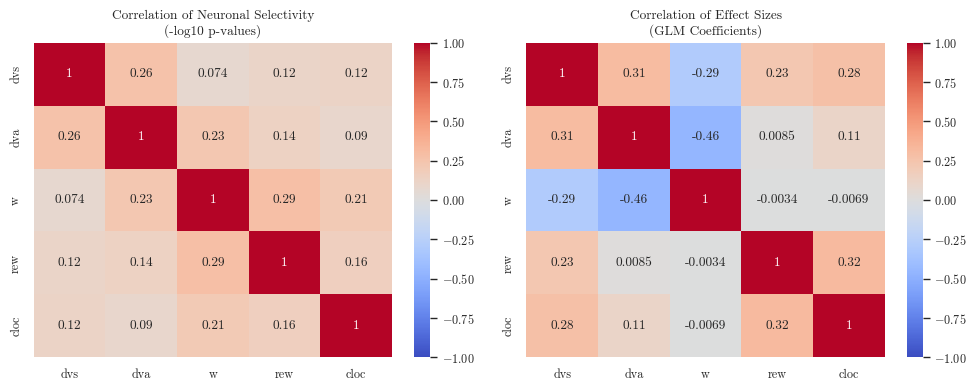

In [159]:
plot_pvalue_and_effectsize_correlation(nef_pval, nef_effectsize)

In [160]:
# plot_all_pairwise_logp_scatter_trend(nef_pval)

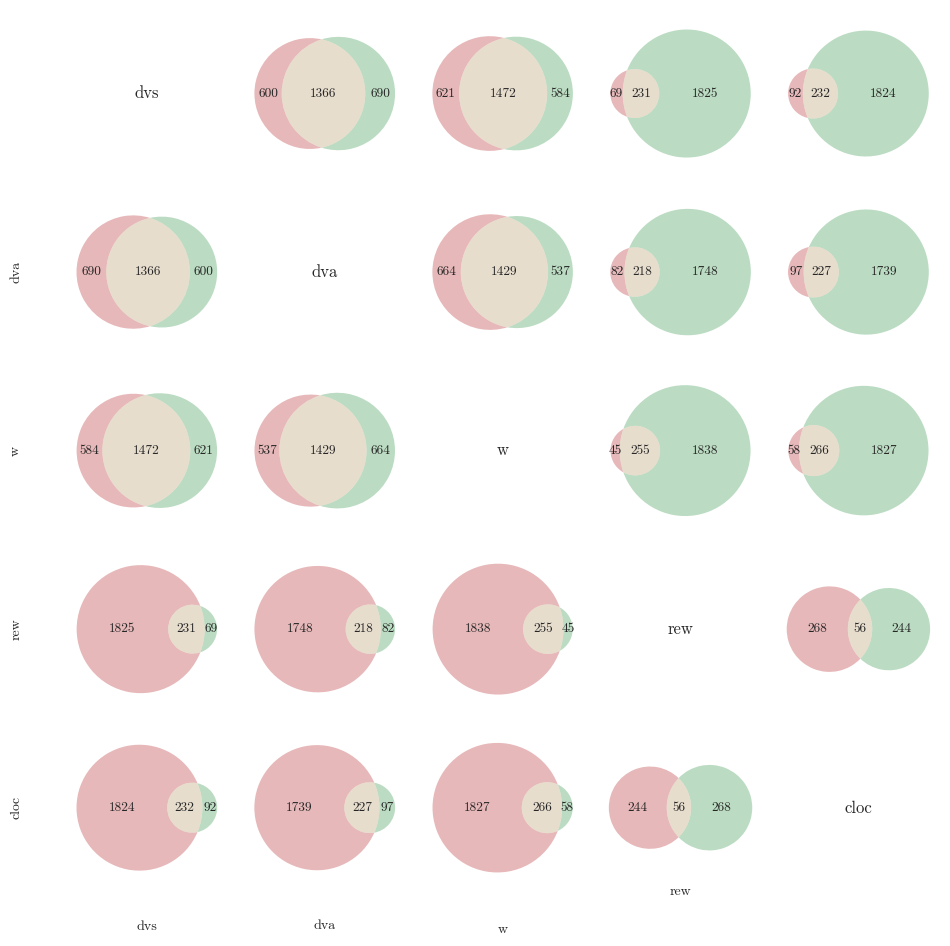

In [161]:
plot_pairwise_venn_grid(nef_pval)

In [153]:
spike_type = 'monkey'
monkey = 'V'
session = 0
# variables = ['V_StimL', 'V_StimR', 'V_Act1', 'V_Act2', 'omega']
variables = ['DeltaV_Stim', 'DeltaV_Act', 'omega', 'reward', 'cloc']
if spike_type=='nef':
    W, S, V = nef_weights, nef_spikes, nef_values
else:
    W, S, V = monkey_weights, monkey_spikes, rl_values

monkey_pvals, monkey_effectsize, monkey_vif = run_glm_and_anova(S, V, monkey=monkey, session=session, variables=variables)

/home/psipeter/arbitration/venv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Neuron 124 failed: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


/home/psipeter/arbitration/venv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Neuron 171 failed: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


In [154]:
monkey_vif

const          8.047400
DeltaV_Stim    1.612442
DeltaV_Act     1.423621
omega          1.003594
reward         1.003578
cloc           1.995646
dtype: float64

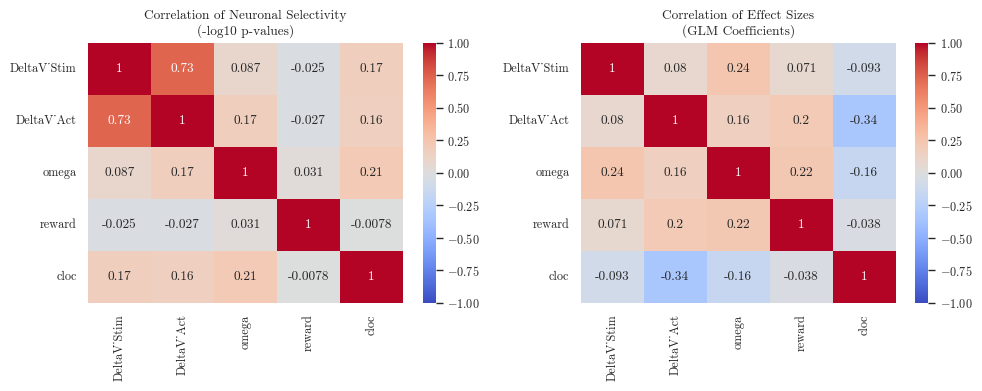

In [155]:
plot_pvalue_and_effectsize_correlation(monkey_pvals, monkey_effectsize)

In [147]:
# plot_all_pairwise_logp_scatter_trend(monkey_pvals)

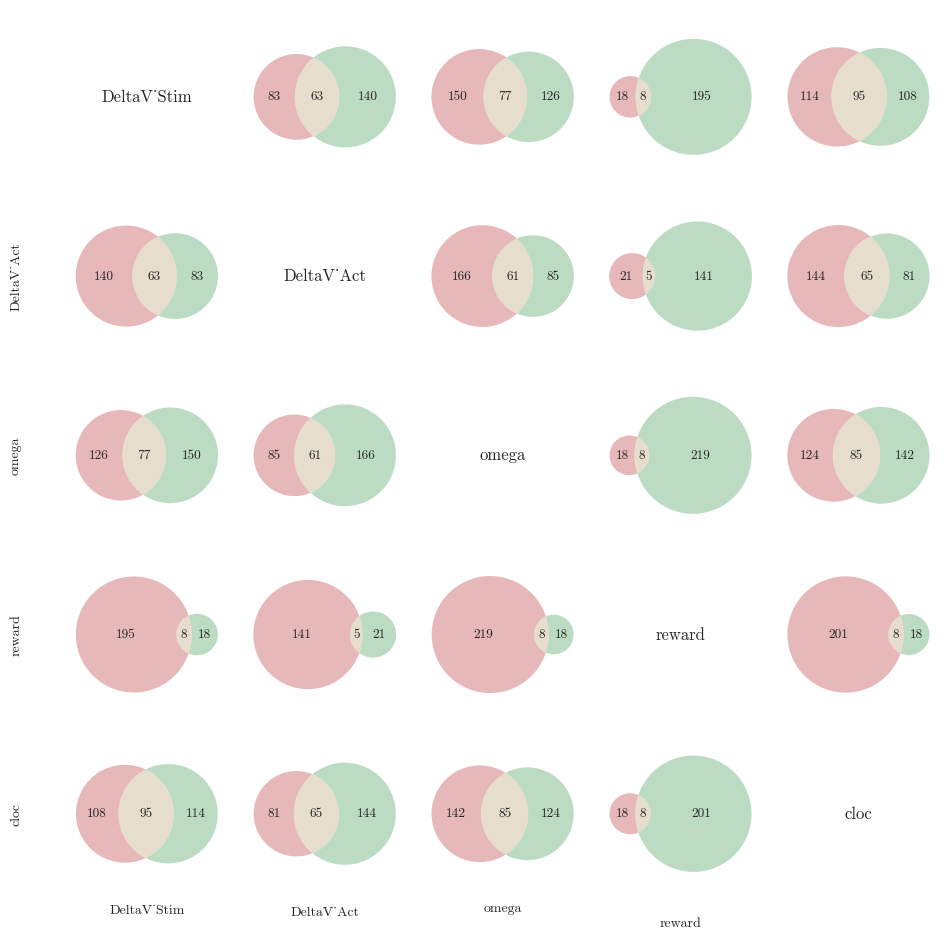

In [156]:
plot_pairwise_venn_grid(monkey_pvals)

In [ ]:
a = np.load('data/nef_